# Script to predict dynamic time stepping of an ocean model

Written by Rachel Furner, April 2019.

Collaborative work with colleagues at BAS, and the ATI



1. Read in the data
2. Define input data and output data.
3. Split into test and train data.
4. Train the network
5. Run predictions on test data and assess.

In [77]:
import xarray as xr
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import cv2

import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import MaxPooling3D, Conv3D, UpSampling3D, Cropping3D

import gpflow
from gpflow.kernels import RBF, Periodic, ArcCosine

import pickle

1.13.1


Define variables for this experiment

In [112]:
StepSize = 1000 #number of timesteps forward which we want to predict
SkipOver = 100

Read in data files as Xarrays

In [113]:
DIR = '/Users/rachelfurner/DATA/JasminData/DynPred/'
exp_list = ['4500yr_Windx0.50']
file_names = ['state.0000000000.t001.nc']
file_list =[]
for exp in exp_list:
    print(exp)
    for file in file_names:
        print(file)
        file_list.append(os.path.join(DIR,exp,file))
print(file_list)

4500yr_Windx0.50
state.0000000000.t001.nc
['/Users/rachelfurner/DATA/JasminData/DynPred/4500yr_Windx0.50/state.0000000000.t001.nc']


###### Define Input output pairs
Eventual aim is that inputs are full model field at t-stepsize and t, outputs are full model fields at t+StepSize.
For now, input is just Temp at just at time step t, and output is Temp at t+stepsize.

In future could involve lots of input variables.

StepSize can be changed easily (defined further up) - plan to test different values and see how well things work.

We take input,output pairs with 't' spaced by 'SkipOver' steps apart. Currently this is set as 1, but ideally would be larger, in bid to ensure some independance between samples. Balance between low values giving us lots of training samples, but also a desire for independant training samples

Need to amend below to loop through multiple files, so more training data, including data from different runs can be included.


In [114]:
training_data=[]
for file in file_list:
    ds   = xr.open_dataset(file)
    for time in range(StepSize, len(ds.T.data)-StepSize, SkipOver):
        training_data.append([ds.Temp.isel(T=time-StepSize), ds.Temp.isel(T=time), ds.Temp.isel(T=time+StepSize)])
        #training_data.append([ds.Temp.isel(T=time-StepSize), ds.Temp.isel(T=time),
        #                      ds.S.isel   (T=time-StepSize), ds.S.isel(T=time)   ,
        #                      ds.U.isel   (T=time-StepSize), ds.U.isel(T=time)   ,
        #                      ds.V.isel   (T=time-StepSize), ds.V.isel(T=time)   ,
        #                      ds.Temp.isel(T=time+StepSize),
        #    ])
    
#shuffle dataset
random.shuffle(training_data)
print(training_data[0][0].shape)

(42, 78, 11)


Plot two fields, 100 time steps apart

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-226e631c-180/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 25, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-226e631c-180/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 25, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-226e631c-180/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 25, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
   

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-226e631c-180/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 25, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
   

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-4fe05a07-183/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._buil

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-4fe05a07-183/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._buil

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-4fe05a07-183/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_pr

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-4fe05a07-183/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_pr

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-5d477b57-190/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 22, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-5d477b57-190/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 22, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-5d477b57-190/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 22, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
   

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-5d477b57-190/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 22, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
   

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-5d477b57-190/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 22, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-5d477b57-190/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-101-413c247d9f81>", line 22, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-226e631c-180/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 25, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-226e631c-180/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 25, in <module>
    model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 83, in _build
    self._objective =

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-f0c9d09d-173/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_pr

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-f0c9d09d-173/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_pr

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-f0c9d09d-173/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._buil

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-f0c9d09d-173/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-100-f5e215cd7aa9>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._buil

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-b4629359-170/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 25, in <module>
    model = gpflow.models.GPR(inputs, outputs, kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()  File "/Users/rachelfurner/anac

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-b4629359-170/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 25, in <module>
    model = gpflow.models.GPR(inputs, outputs, kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()  File "/Users/rachelfurner/anac

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-b4629359-170/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 25, in <module>
    model = gpflow.models.GPR(inputs, outputs, kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()  File "/Users/rachelfurner/anac

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-b4629359-170/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 25, in <module>
    model = gpflow.models.GPR(inputs, outputs, kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()  File "/Users/rachelfurner/anac

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-28ec26b7-163/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_pri

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-28ec26b7-163/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build_pri

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-28ec26b7-163/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern52-28ec26b7-163/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 21, in <module>
    k = gpflow.kernels.Matern52(1, lengthscales=0.3)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 91, in __init__
    self.initialize(force=True)  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/params/parameterized.py", line 302, in _build
    self._prior_tensor = self._build

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-b4629359-170/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 25, in <module>
    model = gpflow.models.GPR(inputs, outputs, kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()  File "/Users

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-b4629359-170/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-99-d6ac8576eafe>", line 25, in <module>
    model = gpflow.models.GPR(inputs, outputs, kern=k )  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/Users/rachelfurner/anaconda3/lib/python3.6/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()  File "/Users

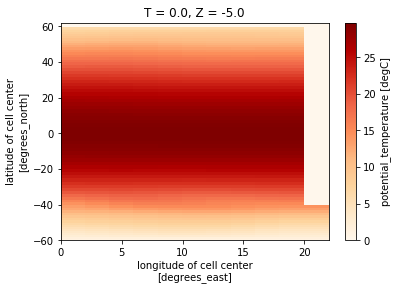

In [115]:
ds.Temp
fig, ax = plt.subplots(ncols=1)
ds.Temp.isel(T=0,Z=0).plot(cmap='OrRd')
fig.savefig('start.png')


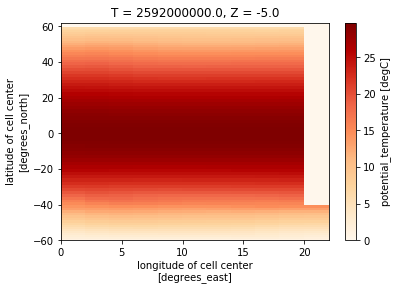

In [116]:
fig, ax = plt.subplots(ncols=1)
ds.Temp.isel(T=StepSize,Z=0).plot(cmap='OrRd')
fig.savefig('end.png')


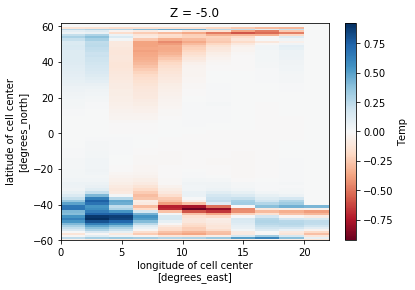

In [117]:
fig, ax = plt.subplots(ncols=1)
(ds.Temp.isel(T=StepSize,Z=0)-ds.Temp.isel(T=0,Z=0)).plot(cmap='RdBu' )
fig.savefig('diff.png')

Put this into X and Y arrays, ready for model to read

If using multiple input variables pad with NaN's so the arrays are all the same size (not done above, as it changes them to arrays, and easier to leave as lists) - not needed when just looking at temp

In [118]:
X=[]
Y=[]

#for feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label in training_data:
#        X.append([
#            np.pad(feat1.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat2.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat3.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat4.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat5.data, ((0,0),(0,1),(0,0)),'constant', constant_values=('NaN')),
#            np.pad(feat6.data, ((0,0),(0,1),(0,0)),'constant', constant_values=('NaN')),
#            np.pad(feat7.data, ((0,0),(0,0),(0,1)),'constant', constant_values=('NaN')),
#            np.pad(feat8.data, ((0,0),(0,0),(0,1)),'constant', constant_values=('NaN')),
#             ])
#        Y.append(np.pad(label.data, ((0,0),(0,1),(0,1)),'constant', constant_values=('NaN')))

for feat1,feat2,label in training_data:
        #X.append([feat1.data feat2.data])
        X.append(feat1.data)
        Y.append(label.data)

# convert to arrays, as model wont accept a list
#X=np.array(X).transpose(0, 2, 3, 4, 1)
X=np.array(X)
Y=np.array(Y)

print(X.shape)
print(Y.shape)

(9, 42, 78, 11)
(9, 42, 78, 11)


Normalise data

In [119]:
def normalise_data(X):
    X=tf.keras/utils.normalize(X, axis=1)
    return X

print(X.shape[1:])

(42, 78, 11)


Trying a GP regressor for a single data point

In [124]:
coordx = 1
coordy = 1
coordz = 1

inputs = []
outputs = []
for time in range(StepSize, len(ds.T.data)-StepSize, SkipOver):
    Xnew = ds.Temp.isel(T=time)
    inputs.append([Xnew[coordx,coordy,coordz]])
          #Xnew[coordx,coordy+1,coordz],   Xnew[coordx,coordy-1,coordz],
          #Xnew[coordx+1,coordy,coordz],   Xnew[coordx-1,coordy,coordz],
          #Xnew[coordx+1,coordy+1,coordz], Xnew[coordx-1,coordy-1,coordz],
          #Xnew[coordx+1,coordy-1,coordz], Xnew[coordx-1,coordy+1,coordz]])
    outputs.append([ds.Temp.isel(T=time+StepSize)[coordx+40,coordy+76,coordz+9]])


inputs=np.array(inputs)
outputs=np.array(outputs)


k = gpflow.kernels.Matern52(1, lengthscales=0.3)
model = gpflow.models.GPR(inputs.astype('float64'), outputs.astype('float64'), kern=k )

#
### Optimise
print('training')
gpflow.train.ScipyOptimizer().minimize(model, disp=True)


training
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -52.747964
  Number of iterations: 16
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -52.747964
  Number of iterations: 16
  Number of functions evaluations: 19


Try a single Layer NN, with the identity (i.e. linear) as the activation function to test basic set up (persistance forecast)

In [54]:
model = Sequential()
model.add(Activation('linear'))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.15)

Train on 24 samples, validate on 5 samples
Epoch 1/3
24/24 [==============================] - 0s 5ms/sample - loss: 1.6138e-05 - acc: 0.9861 - val_loss: 0.0016 - val_acc: 0.9385
Epoch 2/3
24/24 [==============================] - 0s 1ms/sample - loss: 1.6138e-05 - acc: 0.9861 - val_loss: 0.0016 - val_acc: 0.9385
Epoch 3/3
24/24 [==============================] - 0s 792us/sample - loss: 1.6138e-05 - acc: 0.9861 - val_loss: 0.0016 - val_acc: 0.9385


In [ ]:
model = Sequential()

#'flatten' inputs
model.add(Flatten())  
# define first hidden layer
model.add(Dense(36036))
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.15)



Train on 2413 samples, validate on 426 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3


##### NN Attempt 1 - an autoencoder type approach

I assume that data shape is important here, and so a CNN the way to go, and have tried this with pooling layers, to get something resembling an autoencoder.  Cannot yet get the output shape to match up with the y-fields, due to the odd number of layers, and the pooling vs upscaling does not return the original shape...

Also, not convinced auto-encoder approach is best option here.


In [20]:
model = Sequential()

#first downsample/encode
model.add(Conv3D(32, (3, 3, 3), input_shape=X.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))  # output shape 

model.add(Conv3D(64, (3, 3, 3), padding='same'))             # output shape 
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))  # output shape 

model.add(Conv3D(128, (3, 3, 3), padding='same'))             # output shape
model.add(Activation('relu'))

#Now upsample/decode
model.add(Conv3D(128, (3, 3, 3), padding='same'))             # output shape 
model.add(Activation('relu'))
model.add(UpSampling3D(size=(2, 2, 2)))                       # output shape

model.add(Conv3D(64, (3, 3, 3), padding='same'))              # output shape 
model.add(Activation('relu')) 
model.add(UpSampling3D(size=(2, 2, 2)))                       # output shape 

model.add(Conv3D(1, (3, 3, 3), padding='same'))              # output shape
model.add(Activation('relu'))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

#fit the model - Batch size is how much to pass at once, don't want to pass all at once. 
#validation split - how much is train vs test data.
model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.15)

ValueError: Input 0 of layer conv3d is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: [None, 42, 78, 11]

##### NN attempt 2

As Above fails with check, and concerns on whether I should be pooling and thus loosing some information, here I try using just conv layers - no pooling, so no longer autoencoder type set up.

This runs, but results are diabolical....

Number of inputs = 42*78*11*2 = 72072 inputs. This is huge...

In [21]:
model = Sequential()

model.add(Conv3D(72072, (3, 3, 3), input_shape=X.shape[1:], padding='same'))  #no shape change with padding...
model.add(Activation('relu'))
model.add(Conv3D(72072, (5, 5, 5), input_shape=X.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(72072, (3, 3, 3), input_shape=X.shape[1:], padding='same'))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=128, epochs=3, validation_split=0.2)

ValueError: Input 0 of layer conv3d_1 is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: [None, 42, 78, 11]

##### NN Attemmpt 3:

Also tried with Dense layers instead...


In [ ]:
model = Sequential()

#'flatten' inputs
model.add(Flatten())   # should be dim 960
# define first hidden layer
model.add(Dense(72072))
model.add(Activation('relu'))
#add second hidden layer 
model.add(Dense(72072))
model.add(Activation('relu'))
#add third layer - output payer
model.add(Dense(72072))
#ouput layer should have linear activation function suitable for a regression problem
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))


model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=128, epochs=3, validation_split=0.2)

##### NN Attempt 4

A combination of Conv and dense layers...

In [ ]:
model = Sequential()

model.add(Conv3D(72072, (3, 3,3), input_shape=X.shape[1:], padding='same'))
model.add(Activation('relu'))

model.add(Conv3D(72072, (5, 5, 5), padding='same'))
model.add(Activation('relu'))

model.add(Conv3D(72072, (7, 7, 7), padding='same'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(72072))
#last layer should have linear activation function suitable for a regression problem
model.add(Activation('linear'))
#reshape
model.add(Reshape(Y.shape[1:]))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=128, epochs=3, validation_split=0.2)